In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ppr.path import TolerancedNumber, TrajectoryPt

In [3]:
# create tolerances for x-position and orientation
dx    = TolerancedNumber(1, 0.9, 1.1, samples=3)
angle = TolerancedNumber(0.0, -0.5, 0.5, samples=5)

# create a list with path points
path1 = []
n_path = 6
for i in range(n_path):
   yi = 0.3 + i * 0.6 / n_path
   path1.append(TrajectoryPt([dx, yi, angle]))

In [4]:
from ppr.robot import Robot_2P3R

In [5]:
robot1 = Robot_2P3R([1, 1, 0.5, 0.5, 0.3])

In [6]:
from ppr.geometry import Rectangle

In [7]:
sc1 = [Rectangle(0.0, 0.4, 0.1, 0.2, -0.3),
       Rectangle(0.2, 0.8, 0.1, 0.5, 0.2)]

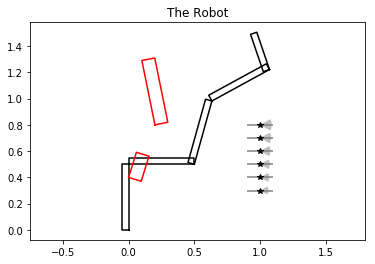

In [8]:
fig1, ax1 = plt.subplots()
plt.title("The Robot")
ax1.axis('equal')
robot1.plot(ax1, [0.5, 0.5, 1.3, -0.8, 1.4], 'k')
for tp in path1: tp.plot(ax1)
for r in sc1: r.plot(ax1, 'r')
plt.show()

# Sampling based path following

In [9]:
from ppr.path import cart_to_joint

The following function can be quit slow. I have c++ code for collision checking between rectangles to improve performance by a factor 5 or so. Should at this to the master branch.

In [10]:
robot1.ik_samples = [6, 6]
path_js = cart_to_joint(robot1, path1, check_collision=True, scene=sc1)

In [11]:
# show the number of sampled joint positions for every trajectory point
[qp.shape[0] for qp in path_js]

[334, 327, 318, 305, 279, 247]

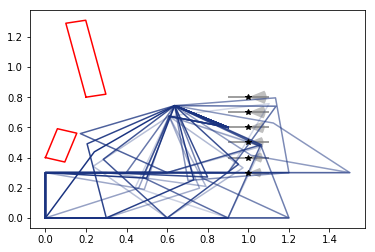

In [12]:
fig2, ax2 = plt.subplots()
robot1.plot_path_kinematics(ax2, path_js[3][1:30])
for tp in path1: tp.plot(ax2)
for r in sc1: r.plot(ax2, 'r')
plt.show()

In [13]:
from ppr.path import get_shortest_path

In [ ]:
sol = get_shortest_path(path_js)
print(sol['success'])

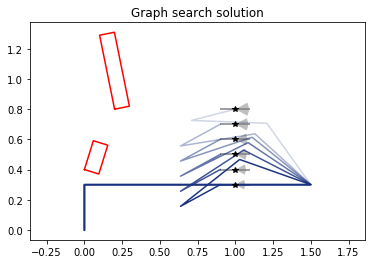

In [16]:
fig3, ax3 = plt.subplots()
plt.title("Graph search solution")
ax3.axis('equal')
robot1.plot_path_kinematics(ax3, sol['path'])
for tp in path1: tp.plot(ax3)
for r in sc1: r.plot(ax3, 'r')
plt.show()

# Optimisation based path following

In [17]:
from ppr.optim import get_optimal_trajectory

In [18]:
robot1.set_link_inertia([1, 1, 1, 0.5, 0.5],
                        [0.5, 0.5, 0.25, 0.25, 0.15],
                        [0.05, 0.05, 0.05, 0.05, 0.05])
q_init = sol['path']

In [19]:
q_opt, dq_opt, ddq_opt = get_optimal_trajectory(robot1, path1, q_init)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.500011458368697
            Iterations: 91
            Function evaluations: 3142
            Gradient evaluations: 91


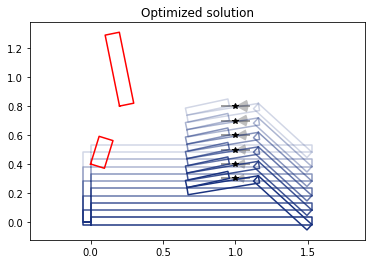

In [20]:
fig4, ax4 = plt.subplots()
plt.title("Optimized solution")
ax4.axis('equal')
robot1.plot_path(ax4, q_opt)
for tp in path1: tp.plot(ax4)
for r in sc1: r.plot(ax4, 'r')
plt.show()

## Use collision constraints

In [22]:
q_opt2, dq_opt2, ddq_opt2 = get_optimal_trajectory(robot1, path1, q_init,
                                               check_collision=True, scene=sc1)

Iteration limit exceeded    (Exit mode 9)
            Current function value: 0.5920797924354823
            Iterations: 101
            Function evaluations: 3378
            Gradient evaluations: 101


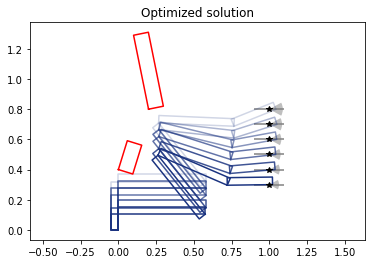

In [23]:
fig5, ax5 = plt.subplots()
plt.title("Optimized solution")
ax5.axis('equal')
robot1.plot_path(ax5, q_opt2)
for tp in path1: tp.plot(ax5)
for r in sc1: r.plot(ax5, 'r')
plt.show()